# Phase 4 Project SubmissionÂ¶
- Student name: Lucas Wilkerson
- Student pace: Flex/part time
- Scheduled project review date/time:
- Instructor name: Morgan Jones

# Pneumonia Detection and Classification

## Business Problem and Stakeholder

A healthcare physician group is looking to improve their patient outcomes, specifically patients who are being diagnosed with pneumonia. Pneumonia is a significant health concern among patients, especially geriatric and pediatric patients. For effective treatment and the best possible outcomes, early detection and diagnosis is crucial so that treatment can be initiated as soon as possible. Current methods for diagnosing pneumonia can be time-consuming and can be prone to error. Through the development and use of method such as image classification and deep learning, we may be able to improve this process which can lead to an increase in early accurate identification and as a result improve patient outcomes.



## Data Understanding 

For this project, the aim is to build a convolution neural network (CNN)  model for image classification that can classify whether a patient has pneumonia when provided a chest x-ray image. A Kaggle dataset containing 5856 chest x-ray images was utilized to construct this model. The chest X-ray images were from pediatric patients with or without pneumonia who are ages one to five and were split into 3 separate datasets: 

- Train (5216 images): data used for training the model
- Test (624 images): data used for testing and evaluating the model's performance 
- Validation (16 images): data used during the training process to help tune the model

## Data Preparation 

Before building the model, the data underwent several preprocessing steps including:
- Data distribution analysis to understand the class balance or imbalance
- Visualizing sample images to get a visual sense of the data
- Checking the image dimensions to ensure they were suitable for the model.

During data preparation and preprocessing: 
- ImageDataGenerator from Keras was used for data augmentation to increase class diversity
- All images were rescaled and normalized to the range [0,1]
- Class imbalance was accounted for by balancing class weights

The data was also subsampled for the modeling process to allow for shorter computation run times. Twenty percent of the data was used for training. 


## Modeling

### Baseline Model/ Model 1: 
A Baseline Convolutional Neural Network (CNN) model was constructed for the image classification. The basic architecture comprises convolutional layers with increasing filters, followed by max-pooling layers to capture features. Flattened outputs are fed through dense layers. The model is compiled with binary cross-entropy loss and trained for ten epochs using training and validation data, enabling it to learn and enhance its classification capabilities over time. The main metrics used to evaluate model performance included accuracy and recall. The baseline model had a test accuracy of 0.7500 and test recall of 0.7510.


### Best Performing Model/ Model 2:
The Best Model had the same initial architecture as the baseline model with adjustments made to the learning rate and to number of filters in the convalutional layers. Learning rate was adjust to 0.001 and filter numbers were doubled compared to the baseline model. The Best Model had a test accuracy of 0.8221 and test recall of 0.8103, which indicates that the model correctly labeled ~82% of the chest x-ray images that were observed in the test group and that out of all of the individuals/patients that actually had pneumonia, the model correctly identified ~81% of those. Performance with test recall, test accuracy, train recall, and train accuracy were all improved.


| Metric                  | Baseline                          | Best Model                        |
|-------------------------|-----------------------------------|-----------------------------------|
| Train Accuracy          | 0.8111                            | 0.8773                            |
| Test Accuracy           | 0.7500                            | 0.8221                            |
| Train Loss              | 0.4179                            | 0.2917                            |
| Test Loss               | 0.6010                            | 0.5218                            |
| Train Recall            | 0.7510                            | 0.8348                            |
| Test Recall             | 0.6513                            | 0.8103                            |


## Evaluation

The Best Model is the ideal model to choose here because it performs better at correctly classifying images with pneumonia as shown by the improved test accuracy and improved test recall, the metrics of importance for this context.  While this model is higher with recall and correctly identifying those with pneumonia, there is the chance for more false positive results (individuals being classified as having pneumonia who in fact do not). This is more ideal because we would rather correctly identify positive cases than to not identify someone with pneumonia and they get left untreated. 


## Data Preparation/ Preprocessing

To start the preparation and preprocessing phase, the necessary packages will be imported for this project. Next a directory path will be made to each of the three dataset groups: training data, test data, validation data. The images will be loaded.

In [1]:
#importing necessary packages

from tensorflow.keras.utils import array_to_img, img_to_array, load_img
from sklearn.utils import class_weight , compute_class_weight
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import tensorflow as tf
from keras import datasets, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization, Activation
from keras import optimizers 
from keras.optimizers import Adam , SGD, RMSprop
from keras.metrics import Accuracy, Recall
from keras.utils import array_to_img, img_to_array, load_img
from keras import regularizers
from keras.regularizers import l1 , l2 
from keras.callbacks import EarlyStopping
import os

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
os.environ['KMP_DUPLICATE_LIB_OK']='True' # This prevents kernel shut down due to xgboost conflict
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # This line prevents tf's comments about the optimizing your machine


In [2]:
# Creating directory path for loading datasets
train_dir = 'chest_xray/train/'
test_dir = 'chest_xray/test/'
val_dir = 'chest_xray/val/'

In [3]:
# Performing data augmentmentation to increase data diversity and possibly mitigate some effects of class imbalance
# All images will be rescaled by 1./255


# Set the seed for reproducibility
np.random.seed(42)


train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)


# Getting all training data (5216 images) 
train_generator = train_datagen.flow_from_directory(
        train_dir,
        batch_size=5216, 
        class_mode='binary')

# Getting all the test data (624 images)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        batch_size=624,
        class_mode='binary')


# Getting all the validation data (16 images)
val_generator = val_datagen.flow_from_directory(
        val_dir,
        batch_size=16, 
        class_mode='binary')

# Creating the datasets
train_images, train_labels = next(train_generator)
test_images, test_labels = next(test_generator)
val_images, val_labels = next(val_generator)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


The images were loaded from each directory.Train, test and validation images and label sets were generated using ImageDataGenerato. Data augmentation was applied to the training set to increase diversity and all sets were rescaled and normalized to a [0,1] scale. 

In [4]:
# Function to get class counts
def get_class_counts(labels):
    unique_classes, class_counts = np.unique(labels, return_counts=True)
    class_counts_dict = dict(zip(unique_classes, class_counts))
    return class_counts_dict

# Get class counts for each dataset
train_class_counts = get_class_counts(train_labels)
test_class_counts = get_class_counts(test_labels)
val_class_counts = get_class_counts(val_labels)

# Print class counts
print("Train Class Counts:", train_class_counts)
print("Test Class Counts:", test_class_counts)
print("Validation Class Counts:", val_class_counts)

# Viewing class indices
train_generator.class_indices

Train Class Counts: {0.0: 1341, 1.0: 3875}
Test Class Counts: {0.0: 234, 1.0: 390}
Validation Class Counts: {0.0: 8, 1.0: 8}


{'NORMAL': 0, 'PNEUMONIA': 1}

## Data Analysis/ Data Visualization

In [5]:
# Previewing shape of each dataset

print("Image Dataset Shape")
print("Train:", train_images.shape)
print("Test:", test_images.shape)
print("Validation:", val_images.shape)

print("Label Dataset Shape")
print("Train:", train_labels.shape)
print("Test:", test_labels.shape)
print("Validation:", val_labels.shape)

# Viewing class indices
train_generator.class_indices

Image Dataset Shape
Train: (5216, 256, 256, 3)
Test: (624, 256, 256, 3)
Validation: (16, 256, 256, 3)
Label Dataset Shape
Train: (5216,)
Test: (624,)
Validation: (16,)


{'NORMAL': 0, 'PNEUMONIA': 1}

### Class Distribution

A function was created to visualize the class counts for each set. 

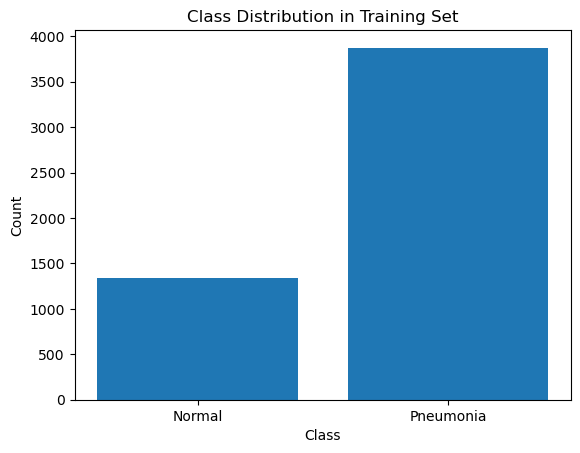

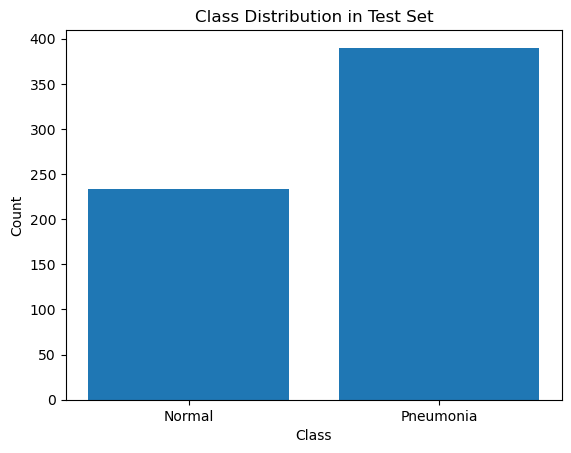

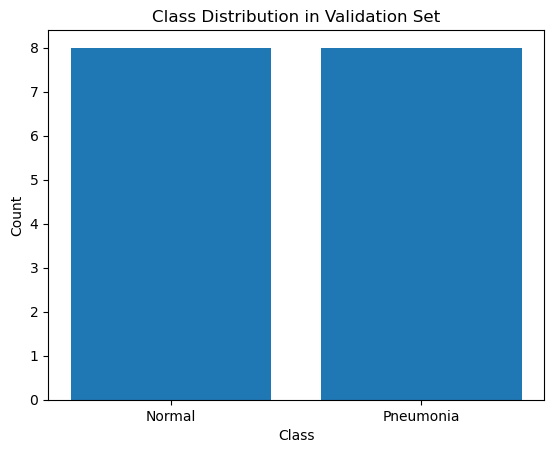

In [6]:
# Get class counts for each set
train_class_counts = np.unique(train_labels, return_counts=True)
test_class_counts = np.unique(test_labels, return_counts=True)
val_class_counts = np.unique(val_labels, return_counts=True)

# Define class labels
class_labels = {0: 'Normal', 1: 'Pneumonia'}

# Plot class distribution
def plot_class_distribution(class_counts, dataset):
    classes, counts = class_counts
    plt.bar(classes, counts)
    plt.title(f'Class Distribution in {dataset} Set')
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.xticks(list(class_labels.keys()), [class_labels[c] for c in classes])  # Set x-axis ticks with labels
    plt.show()

# Plot for training set
plot_class_distribution(train_class_counts, 'Training')

# Plot for test set
plot_class_distribution(test_class_counts, 'Test')

# Plot for validation set
plot_class_distribution(val_class_counts, 'Validation')

Looking at the characteristics of the datasets, we can derive the total number of images per group, along with the size of each image, and the class indices for labeling. Images labeled with a 0 are classified as Normal while images labeled with a 1 are classified as having Pneumonia. From the visualized plots, we can the distribution between individuals with pneumonia and those without. It can be seen that there is a class imbalance with the training set which will be addressed by balancing class weights.

Training set: 5216 images 
- Pneumonia: 3875
- Normal: 1341

Test set: 624 images 
- Pneumonia: 390
- Normal: 234

Validation set: 16 images
- Pneumonia: 8
- Normal: 8

Image size: 256 x 256 x 3

Looking at the whole dataset, there is a total of 5856 images.

- The training set has 3875 images labeled with pneumonia while having 1341 labeled as normal/without pneumonia. This image set seems to have an imbalanced class distribution since there are a long more images with pneumonia. This class imbalance could affect the model's performance and ability to generalize over the data. This class imbalance will be addressed. 


- The test set has 390 images labeled with pneumonia while having 234 labeled as normal/without pneumonia. This image appears to have a more balanced distribution in comparison to the training set. Even though the the pneumonia images count is still higher than the images without pneumonia, the difference is not as vast as the training set.

  
- The validation set has small number of images for both classes with 8 images labeled with pneumonia while having 8 labeled as normal/without pneumonia.



### Previewing Sample Images 

In [7]:
# Previewing sample array of the labels
train_labels[:20]

array([1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 1.], dtype=float32)

0.0


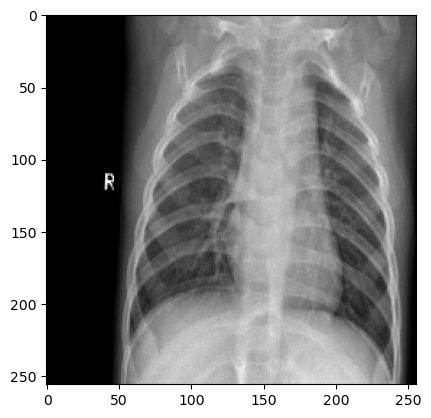

In [8]:
# Previewing sample image from training set
example_img = train_images[8]
plt.imshow(example_img)
print(train_labels[8])

From the image above, we can see this an example of a individual without pneumonia. 

1.0


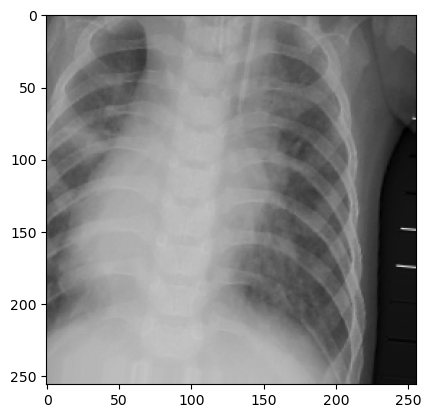

In [9]:
# Previewing sample image from training set
example_img_pne = train_images[2]
plt.imshow(example_img_pne)
print(train_labels[2])

From the image above, we can see this an example of a individual with pneumonia. 

## Data Modeling
### Building a Convolutional Neural Network Model

For pneumonia classficiation I will be building a convolutional neural network (CNN) model. I'll start with a baseline simple CNN and then based on the results, I plan to adjust and iterate as needed to find the optimal best performing model. First I plan to test these models on a smaller subset of the training data for speed of runtimes. After the best model is determined, the whole dataset will be utilized. 

Metrics I will be looking at for evaluation will include accuracy and recall of the model. 

In [10]:
from sklearn.model_selection import train_test_split

# Set the seed for reproducibility
np.random.seed(42)

# Define the percentage of the original training set to use
percentage_to_use = 0.2 

# Split the original training set into a smaller subset
sample_train_images, _, sample_train_labels, _ = train_test_split(
    train_images, train_labels, 
    train_size=percentage_to_use, 
    stratify=train_labels,  # Maintain class distribution
    random_state=42   # Set random seed for reproducibility
)

# Print the shape of the new subset
print("Sample Train Images Shape:", sample_train_images.shape)
print("Sample Train Labels Shape:", sample_train_labels.shape)


Sample Train Images Shape: (1043, 256, 256, 3)
Sample Train Labels Shape: (1043,)


In [11]:
# Define a function to plot training and validation curves
def plot_curves(history):
    # Plot training & validation accuracy values
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

# Define a function to get evaluation metrics
def get_evaluation_metrics(model):

    # Evaluate the model 
    test_evaluation_results = model.evaluate(test_images, test_labels)
    train_evaluation_results = model.evaluate(sample_train_images, sample_train_labels)

    # Print all evaluation results
    print("Test Evaluation Results:", test_evaluation_results)
    print("Train Evaluation Results:", train_evaluation_results)

    # Access specific values
    test_loss = test_evaluation_results[0]
    test_acc = test_evaluation_results[1]
    test_recall = test_evaluation_results[2]
    train_loss = train_evaluation_results[0]
    train_acc = train_evaluation_results[1]
    train_recall = train_evaluation_results[2]


    # Print specific values
    print("Test Loss:", test_loss)
    print("Test Accuracy:", test_acc)
    print("Test Recall:", test_recall)
    print("Train Loss:", train_loss)
    print("Train Accuracy:", train_acc)
    print("Train Recall:", train_recall)

### Baseline Model 

Starting with the baseline CNN model, there will be three convalutional layers and two pooling layers. The model will be flattened and then ran through two dense layers. Binary crossentropy will utilized for loss. Class weights will be balanced

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 8)       0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 62, 62, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 57600)             0

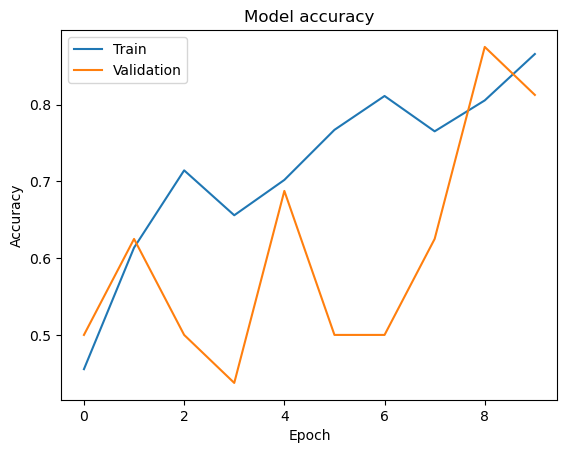

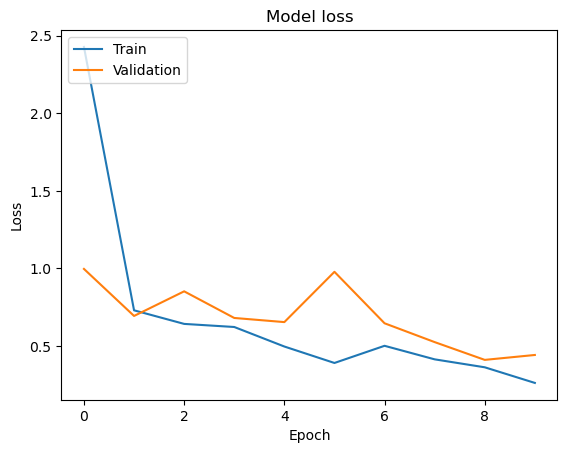

In [12]:
# cnn baseline model

# Set the seed for reproducibility
np.random.seed(42)

cnn_model = models.Sequential()
cnn_model.add(layers.Conv2D(filters= 8, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))
cnn_model.add(layers.MaxPooling2D((2, 2)))
cnn_model.add(layers.Conv2D(16, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(16, activation='relu'))
cnn_model.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
cnn_model.compile(optimizer='adam',
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history = cnn_model.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model)

# Viewing Results 
plot_curves(history)

Looking at the baseline CNN model:

- Test Loss: 0.6010
- Test Accuracy: 0.75
- Test Recall: 0.6513
- Train Loss: 0.4179
- Train Accuracy: 0.8111
- Train Recall: 0.7510


Overall the baseline model did not perform the best initially. Test accuracy was 0.75 with a test recall of 0.6513. Will continue to iterate and adjust to work to improve performance. 

### Model 2 : CNN Learning Late (0.001) and Increased Filters

With the second model, I will be increasing the number of filters in the convolutional layers to introduce more complexity and adjust the learning rate to see if performance can be improved.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 flatten_1 (Flatten)         (None, 115200)           

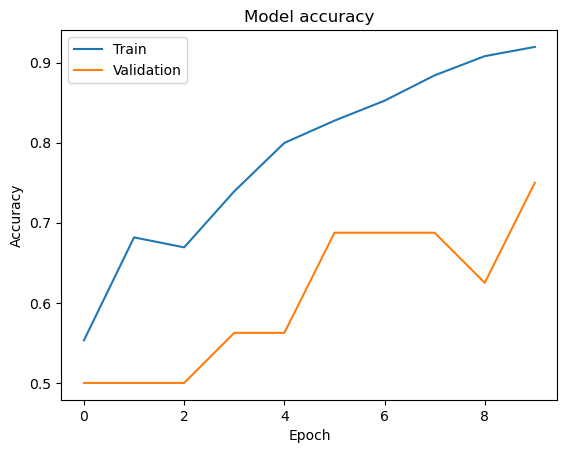

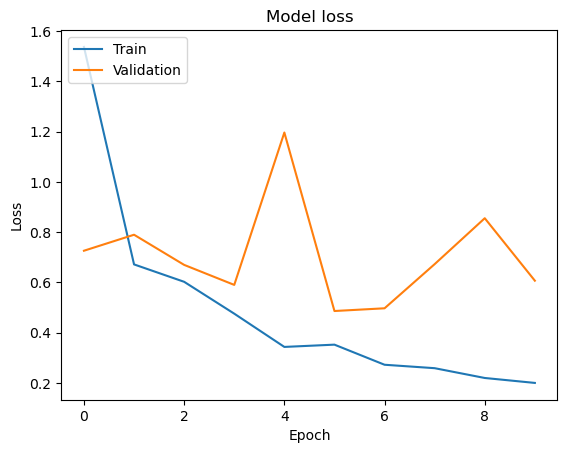

In [13]:
# CNN model 2
# Adjusted learning rate to 0.001 
# Increased filters in convalution layers

# Set the seed for reproducibility
np.random.seed(42)

cnn_model2 = models.Sequential()
cnn_model2.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model2.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model2.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model2.add(layers.MaxPooling2D((2, 2)))
cnn_model2.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model2.add(layers.Flatten())
cnn_model2.add(layers.Dense(16, activation='relu'))
cnn_model2.add(layers.Dense(1, activation='sigmoid'))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model2.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model2.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history2 = cnn_model2.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model2)

# Viewing Results 
plot_curves(history2)

Looking at CNN model 2 with the adjusted learning rate of 0.001 and increased filters:

- Test Loss: 0.5218
- Test Accuracy: 0.8221
- Test Recall: 0.8103
- Train Loss: 0.2917
- Train Accuracy: 0.8773
- Train Recall: 0.8348


With adjusting the learning rate to 0.001 and increased filters, overall model performance improved compared to baseline model. Test accuracy was 0.8221 and test recall was 0.8103 both seeing improvements from baseline. The model does indicate that it is slightly overfitting with having a train accuracy higher than test accuracy. This could potentially be improved with further regularization techniques. 


### CNN Model 3: L2 Regularizar Added to Model 

L2 Regularization was added to the model to account for the slight overfitting.

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 flatten_2 (Flatten)         (None, 115200)           

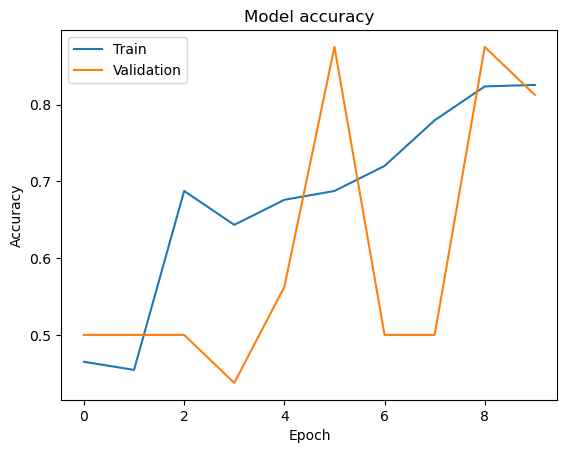

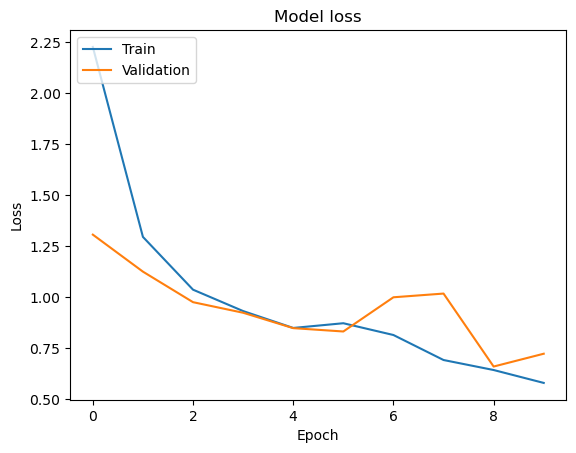

In [14]:
# CNN model  3
# Learning Rate 0.001
# Adding L2 regularization with strength of 0.1 to dense layers

# Set the seed for reproducibility
np.random.seed(42)

cnn_model3 = models.Sequential()
cnn_model3.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model3.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model3.add(layers.MaxPooling2D((2, 2)))
cnn_model3.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model3.add(layers.Flatten())
cnn_model3.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model3.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model3.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model3.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history3 = cnn_model3.fit(sample_train_images, sample_train_labels,
                        epochs=10,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model3)

# Viewing Results 
plot_curves(history3)

Looking at this model's performance, test accuracy slightly decreased from Model 2 but still higher than baseline model. Test recall did improve slightly with this model. Train accuracy did decrease slightly. 

- Test Loss: 0.6337
- Test Accuracy: 0.8029
- Test Recall: 0.8256
- Train Loss: 0.5541
- Train Accuracy: 0.8562
- Train Recall: 0.8168

### CNN Model 4: Epochs Increased to 20

Model 4 will have the same architecture as Model 3 except with an increase to 20 epochs to see if performance can be improved.

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 127, 127, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 62, 62, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 60, 60, 32)        9248      
                                                                 
 flatten_3 (Flatten)         (None, 115200)           

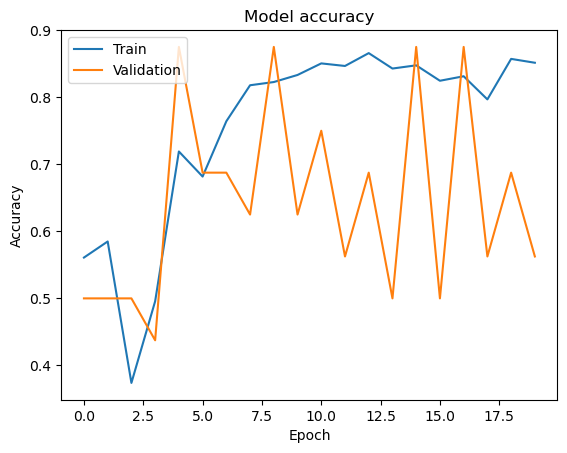

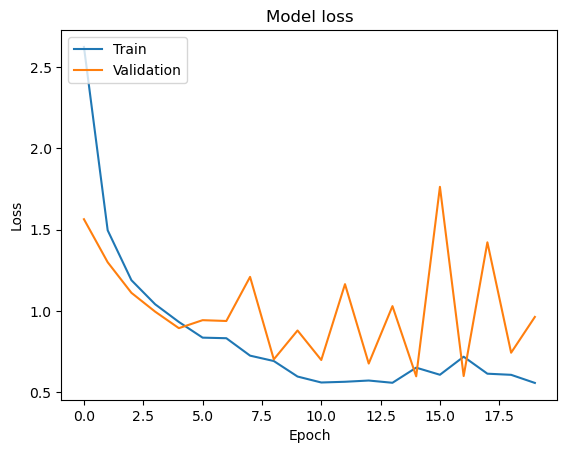

In [15]:
# CNN model 4 --> with 20 epochs 
# Learning rate to 0.001
# L2 regularization 0.1 

# Set the seed for reproducibility
np.random.seed(42)

cnn_model4 = models.Sequential()
cnn_model4.add(layers.Conv2D(filters= 16, 
                        kernel_size=(3,3), 
                        activation='relu', 
                        input_shape=(256, 256, 3)))
cnn_model4.add(layers.MaxPooling2D(pool_size=(2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))
cnn_model4.add(layers.MaxPooling2D((2, 2)))
cnn_model4.add(layers.Conv2D(32, (3, 3), activation='relu'))

# Adding dense layers on top

cnn_model4.add(layers.Flatten())
cnn_model4.add(layers.Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.1)))
cnn_model4.add(layers.Dense(1, activation='sigmoid', kernel_regularizer=regularizers.l2(0.1)))

# Compiling model with following parameters
optimizer = optimizers.Adam(learning_rate=0.001)
cnn_model4.compile(optimizer=optimizer,
                loss='binary_crossentropy', 
                metrics=['accuracy', 'Recall'])

# Inspecting model summary
cnn_model4.summary()

# Balancing class weights to account for class imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: w for i, w in enumerate(class_weights)}


# Fit and train the model 
history4 = cnn_model4.fit(sample_train_images, sample_train_labels,
                        epochs=20,
                        batch_size=128, 
                        class_weight=class_weights_dict, 
                        validation_data=(val_images, val_labels)   
                       )

# Evaluate the model 
get_evaluation_metrics(cnn_model4)

# Viewing Results 
plot_curves(history4)

After increasing epochs to 20, model performance did improve in terms of test recall and train accuracy and train recall compared to model 3. Test accuracy was slightly lower. Train accuracy was higher than test accuracy leading to the model overfitting, however test recall and train recall were closer.

- Test Loss: 0.7545
- Test Accuracy: 0.7837
- Test Recall: 0.9077
- Train Loss: 0.5034
- Train Accuracy: 0.8955
- Train Recall: 0.8903

## Evaluation 

The Best Model/ Model 2 is the ideal model to choose here because it performs better at correctly classifying images with pneumonia as shown by the improved test accuracy and improved test recall, the metrics of importance for this context.  While this model may not have the highest single test accuracy or the highest single test recall, both test recall and test accuracy were both over 80%, with minimal overfitting and the least loss of all the model iterations. 

### Regarding the Best Model Scores:

Metrics of focus
- Recall score: 0.8103
- Accuracy: 0.8221

Accuracy: The model's overall accuracy score was 0.8221 which indicates that the model correctly labeled ~82% of the chest x-ray images that were observed in the test group.

Recall: The model's overall recall score was 0.8103 which means that out of all of the individuals/patients that actually had pneumonia, the model correctly identified ~81% of those.



## Conclusion and Recommendations 

Recommendations: 

- Healthcare providers should utilize this model as a tool for early pneumonia detection. While this model is not an official diagnostic tool for penuamonia, this model is useful for early detecton and screening and can be cross-reference with professional physician observations.  

- Using this model, practitioner's can implement preventative health strategies to their patient population early on before disease progression and improve overall health outcomes. 



## Limitations and Future Considerations

While the model can be useful in the detection of pneumonia from chest x-ray images, the model is not perfect and does have it's limitations.

- False positives: With recall, there is the chance for more false positive results (individuals being classified as having pneumonia who in fact do not). While this can be a limitation at times, this is not a huge hinderance in this context because we would rather correctly identify positive cases than to not identify someone with pneumonia and they get left untreated. 

- Run time/ Model complexity: As model complexity increases, this does increase the requirement for computation power and can increase model run times. 

- Small sample size: With more data and more images to analyze, a more robust model could be utilized to increased accuracy.
 



## Contact Information

- Email: ldwilker10@gmail.com

- GitHub: https://github.com/ldwilker10

- LinkedIn: https://www.linkedin.com/in/lucasdukewilkerson/